<ipython-input-11-f8d07ec1036c>:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('/content/ratings.csv', on_bad_lines='skip')  # <-- Ignora linhas quebradas


userId        object
movieId      float64
rating       float64
timestamp     object
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  83.92


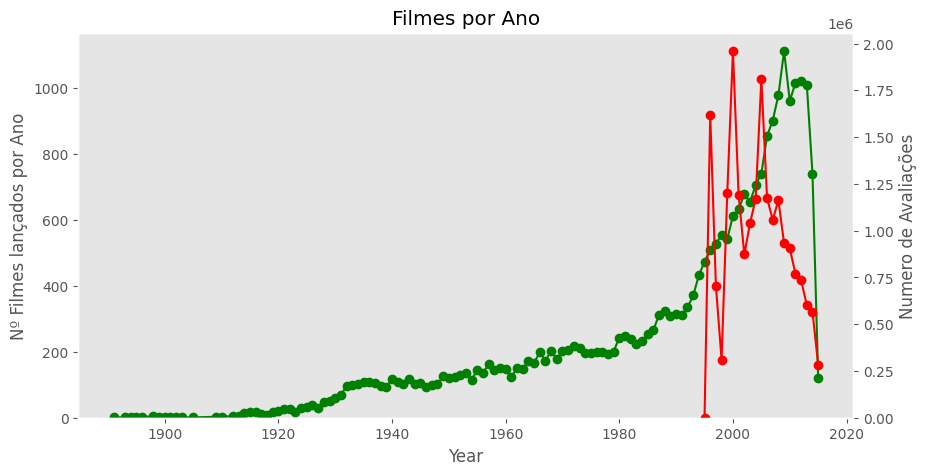

Elapsed time(sec):  0.89


<ipython-input-11-f8d07ec1036c>:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<Figure size 1000x500 with 0 Axes>

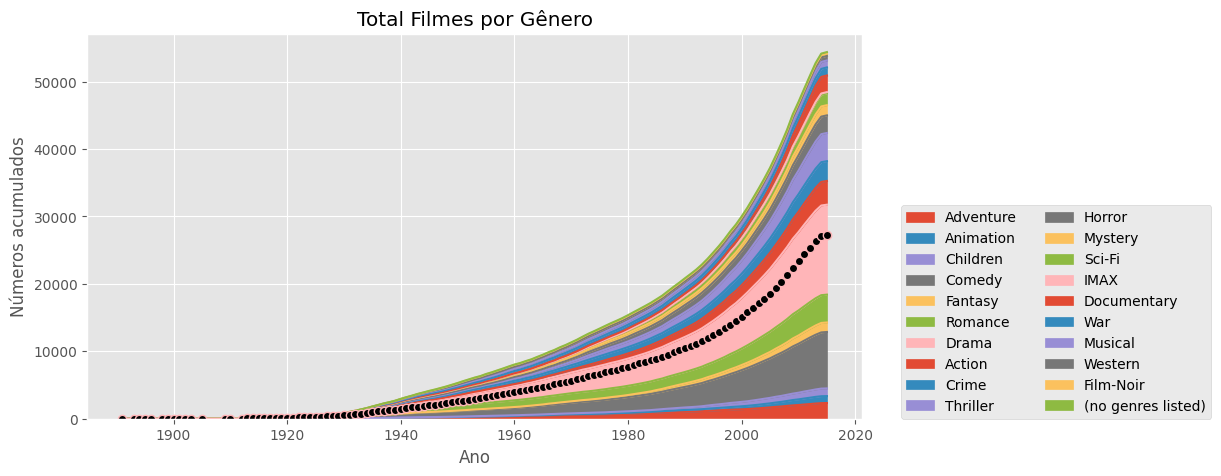

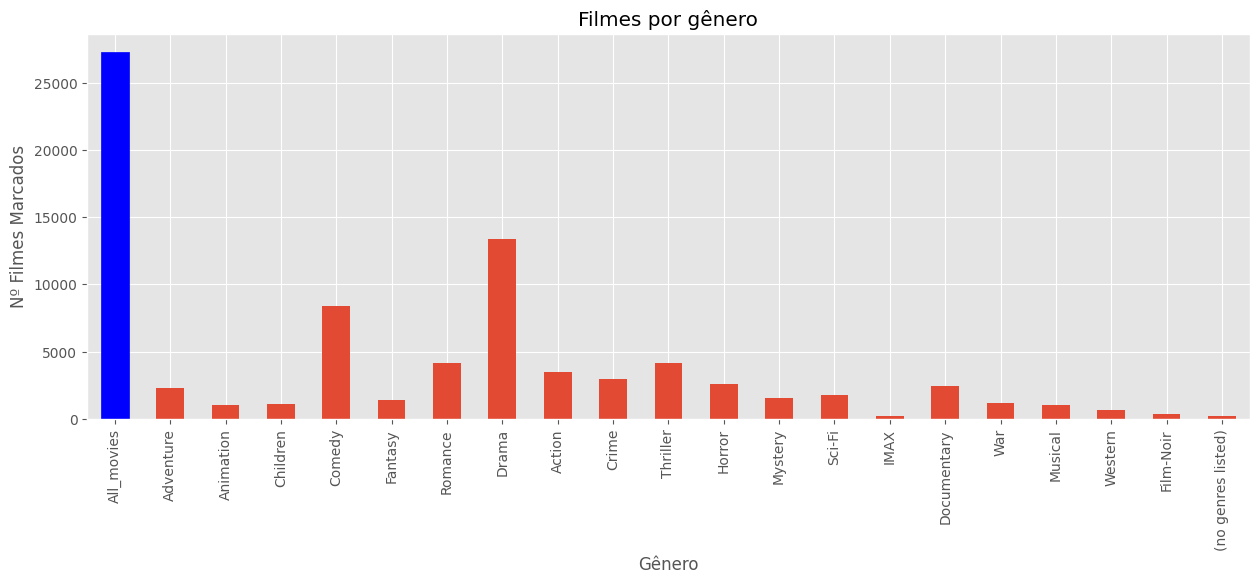

Elapsed time(sec):  0.91


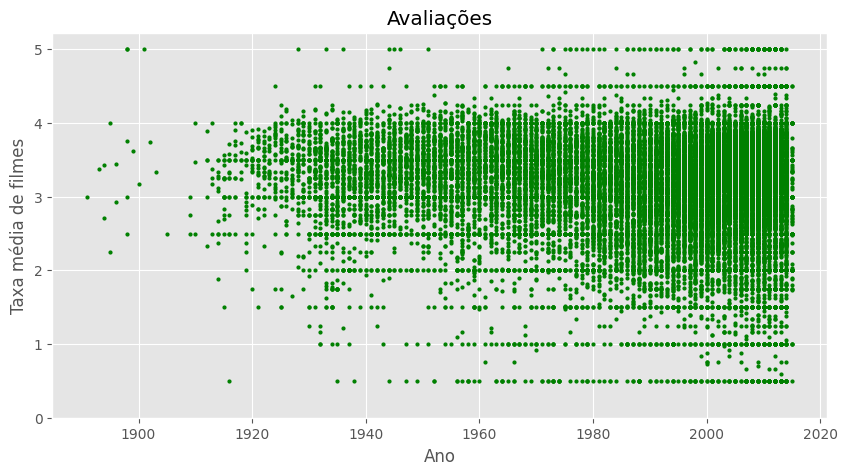

Elapsed time(sec):  1.0


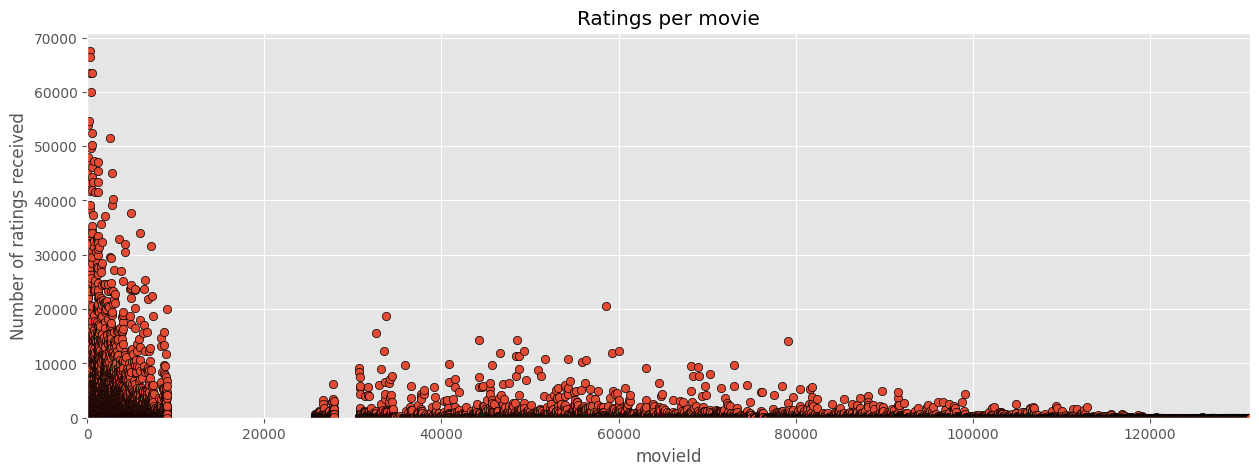

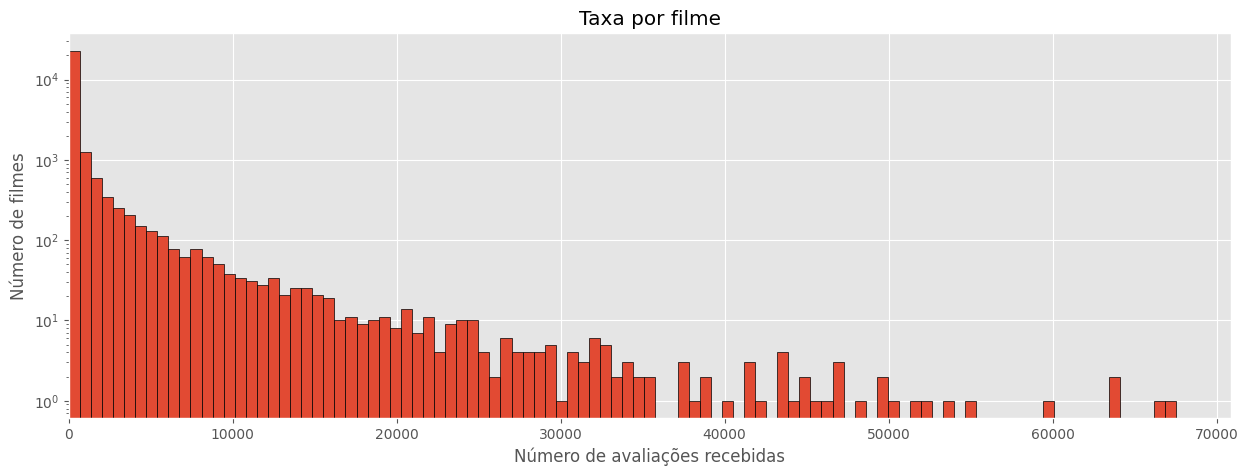

Elapsed time(sec):  9.95


,count
movieId,
296.0,67516
356.0,66393
318.0,63563
593.0,63498
480.0,59914
260.0,54690
110.0,53945
589.0,52421
2571.0,51499


In [ ]:
# Bloco 1 - Carregamento das bibliotecas
from timeit import default_timer
start = default_timer()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Bloco 2 - Importar os arquivos para a memória do APP
st = default_timer()
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv', on_bad_lines='skip')  # <-- Ignora linhas quebradas

# Bloco 3 - Processamento e limpeza de dados
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Separar o título e o ano em colunas separadas
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

# Categorizar os gêneros corretamente
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# ✅ CORREÇÃO: Modificar o formato de timestamp da avaliação sem causar erro
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], errors='coerce')
ratings.dropna(subset=['timestamp'], inplace=True)
ratings['timestamp'] = ratings['timestamp'].dt.year

# Verificar e limpar valores nulos
print("Number of movies Null values: ", max(movies.isnull().sum()))
print("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

# Organizar novamente e resetar índices
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

# Tempo de execução
runtime = default_timer() - st
print("Elapsed time(sec): ", round(runtime, 2))
st = default_timer()

# Trabalhar com uma amostra temporária para visualização
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Nº Filmes lançados por Ano')
ax2.set_ylabel('Numero de Avaliações')
plt.title('Filmes por Ano')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print("Elapsed time(sec): ", round(runtime, 2))
st = default_timer()

plt.figure(figsize=(10, 5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies': dftmp.movieId.nunique().cumsum()})

for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre] = dftmp.movieId.nunique().cumsum()

df.fillna(method='ffill', inplace=True)
df.loc[:, df.columns != 'All_movies'].plot.area(stacked=True, figsize=(10, 5))
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Ano')
plt.ylabel('Números acumulados')
plt.title('Total Filmes por Gênero')
plt.legend(loc=(1.05, 0), ncol=2)
plt.show()

plt.figure(figsize=(15, 5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b')
plt.xticks(rotation='vertical')
plt.title('Filmes por gênero')
plt.xlabel('Gênero')
plt.ylabel('Nº Filmes Marcados')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print("Elapsed time(sec): ", round(runtime, 2))
st = default_timer()

# Gráfico de nota média por ano
dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId', 'rating']].groupby('movieId').mean()
)

plt.figure(figsize=(10, 5))
plt.plot(dftmp.year, dftmp.rating, "g.", markersize=4)
plt.xlabel('Ano')
plt.ylabel('Taxa média de filmes')
plt.title('Avaliações')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print("Elapsed time(sec): ", round(runtime, 2))
st = default_timer()

# Dispersão de número de avaliações por filme
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns = ['num_ratings']
plt.figure(figsize=(15, 5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0, dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histograma da contagem de avaliações
plt.figure(figsize=(15, 5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Taxa por filme')
plt.xlabel('Número de avaliações recebidas')
plt.ylabel('Número de filmes')
plt.xlim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print("Elapsed time(sec): ", round(runtime, 2))

# Exportar arquivos tratados
movies.to_csv('movies_export.csv', index=False)
ratings.to_csv('ratings_export.csv', index=False)

# Top 10 filmes com mais avaliações
ratings['movieId'].value_counts().head(10)

# Exportar apenas 200 linhas do ratings
ratings.head(200).to_csv('ratings_export_200.csv', index=False)




Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [ ]:
# Amostragem de 10.000 linhas aleatórias
ratings_sample = ratings.sample(n=10000, random_state=42)

# Verificar quantos movieId únicos tem na amostra
print("Quantidade de movieId únicos:", ratings_sample['movieId'].nunique())

# Exportar para CSV
ratings_sample.to_csv("ratings_export_10000.csv", index=False)


Quantidade de movieId únicos: 3360


In [ ]:
from google.colab import files
files.download("ratings_export_10000.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Amostragem de 10.000 linhas aleatórias do movies
movies_sample = movies.sample(n=10000, random_state=42)

# Verificar quantos movieId únicos tem na amostra
print("Quantidade de movieId únicos:", movies_sample['movieId'].nunique())

# Exportar para CSV
movies_sample.to_csv("movies_export_10000.csv", index=False)


Quantidade de movieId únicos: 10000


In [ ]:
from google.colab import files
files.download("movies_export_10000.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>